In [3]:
from dqn.agent import CarRacingDQN
import os
import tensorflow as tf
import gym
import _thread
import re
import sys
import numpy as np
from matplotlib import pyplot as plt

import h5py
import pickle
import glob as glob

from car_racing_ellipse import CarRacingEllipse
from car_racing_square import CarRacingSquare
from car_racing_zigzag import CarRacingZigZag
from car_racing_cycle_tracks import CarRacingCycleTracks
from car_racing_cycle_random_tracks import CarRacingCycleRandom

from gym.wrappers.monitoring import Monitor

from sklearn.tree import DecisionTreeClassifier
from CarRacingKM import CarRacingKM

from skimage import color, transform
import itertools as it

model_config = dict(
    min_epsilon=0.1,
    max_negative_rewards=12,
    min_experience_size=int(1e4),
    num_frame_stack=1,
    frame_skip=3,
    train_freq=4,
    batchsize=64,
    epsilon_decay_steps=int(1e5),
    network_update_freq=int(1e3),
    experience_capacity=int(4e4),
    gamma=0.95
)

record_video = False

track_type = 'Cycle Random'

if track_type=='Square':
    env = CarRacingSquare()
elif track_type=='Ellipse':
    env = CarRacingEllipse()
elif track_type=='ZigZag':
    env = CarRacingZigZag()
elif track_type=='Cycle':
    env = CarRacingCycleTracks()
elif track_type=='Cycle Random':
    env = CarRacingCycleRandom()

dqn_agent = CarRacingDQN(env=env, **model_config)
dqn_agent.build_graph()
sess = tf.InteractiveSession()
dqn_agent.session = sess

saver = tf.train.Saver(max_to_keep=100)

if track_type == 'Square':
    checkpoint_path = "data/square_20210608"
elif track_type == 'Ellipse':
    checkpoint_path = "data/ellipse_20210608"
elif track_type == 'ZigZag':
    checkpoint_path = 'data/zigzag_20210608'
elif track_type == 'Cycle' or track_type == 'Cycle Random':
    checkpoint_path = '/home/dahlin/Desktop/Car Racing/DQN/data/checkpoint_20210225_num_frame_stack_1_frame_skip_3/Checkpoints'

print("loading the latest checkpoint from %s" % checkpoint_path)
ckpt = tf.train.get_checkpoint_state(checkpoint_path)
assert ckpt, "checkpoint path %s not found" % checkpoint_path
global_counter = int(re.findall("-(\d+)$", ckpt.model_checkpoint_path)[0])
saver.restore(sess, ckpt.model_checkpoint_path)
#dqn_agent.global_counter = global_counter

dqn_agent.do_training = False
dqn_agent.do_rollouts = True

save_freq_episodes = 5

print(dqn_agent.get_epsilon())
print(dqn_agent.global_counter)

model_folder = sorted(glob.glob(os.path.join(checkpoint_path,'Students','KM','*','')),key=os.path.getmtime)[-1]
video_path = os.path.join(model_folder,'Videos')

if record_video:
    env = Monitor(env, video_path, force=True)
# save_path = 'data/square/hard_trees_frames_48664_train_points/'
test_episodes = 3
# min_depth = 8
# #max_depth = 10
# max_depth = 20
max_neg_rewards=12

def process_image(obs):
    return 2 * color.rgb2gray(obs) - 1.0

all_actions = np.array(
            [k for k in it.product([-1, 0, 1], [1, 0], [0.2, 0])]
        )
action_map=all_actions

def check_early_stop(reward, totalreward):
    if reward < 0:
        neg_reward_counter += 1

def check_early_stop(reward, totalreward):
    if reward < 0:
        neg_reward_counter += 1
        done = (self.neg_reward_counter > self.max_neg_rewards)

        if done and totalreward <= 500:
            punishment = -20.0
        else:
            punishment = 0.0  
        if done:
            self.neg_reward_counter = 0

        return done, punishment
    else:
        self.neg_reward_counter = 0
        return False, 0.0

ValueError: Variable fixed/Conv/weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/home/dahlin/Desktop/Car Racing/car_racing_retry/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 277, in variable
    aggregation=aggregation)
  File "/home/dahlin/Desktop/Car Racing/car_racing_retry/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/home/dahlin/Desktop/Car Racing/car_racing_retry/lib/python3.6/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 350, in model_variable
    aggregation=aggregation)


In [2]:
model_folder
models = sorted(glob.glob(os.path.join(model_folder,'model*.pkl')),key=os.path.getmtime)
models

['/home/dahlin/Desktop/Car Racing/DQN/data/checkpoint_20210225_num_frame_stack_1_frame_skip_3/Checkpoints/Students/KM/KM_frames_2497_train_points/model_0.pkl',
 '/home/dahlin/Desktop/Car Racing/DQN/data/checkpoint_20210225_num_frame_stack_1_frame_skip_3/Checkpoints/Students/KM/KM_frames_2497_train_points/model_1.pkl',
 '/home/dahlin/Desktop/Car Racing/DQN/data/checkpoint_20210225_num_frame_stack_1_frame_skip_3/Checkpoints/Students/KM/KM_frames_2497_train_points/model_2.pkl',
 '/home/dahlin/Desktop/Car Racing/DQN/data/checkpoint_20210225_num_frame_stack_1_frame_skip_3/Checkpoints/Students/KM/KM_frames_2497_train_points/model_3.pkl',
 '/home/dahlin/Desktop/Car Racing/DQN/data/checkpoint_20210225_num_frame_stack_1_frame_skip_3/Checkpoints/Students/KM/KM_frames_2497_train_points/model_4.pkl',
 '/home/dahlin/Desktop/Car Racing/DQN/data/checkpoint_20210225_num_frame_stack_1_frame_skip_3/Checkpoints/Students/KM/KM_frames_2497_train_points/model_5.pkl',
 '/home/dahlin/Desktop/Car Racing/DQN/da

In [3]:
student = pickle.load(open(models[0],'rb'))
scaler = pickle.load(open(os.path.join(model_folder,'scaler.pkl'),'rb'))

student = CarRacingKM(student,scaler,max_negative_rewards=max_neg_rewards)

    #env_name = "CarRacing-v0"
    #env = gym.make(env_name)

frame_skip = 3
render = 1

total_reward = 0
frames_in_episode = 0
obs = env.reset()
#print(env.stats_recorder.done)
#plt.figure()
#plt.imshow(process_image(obs))

acts = []

while True:

    obs_pp = process_image(obs)
    obs_pp = obs_pp.reshape((1,-1))
    obs_pp = scaler.transform(obs_pp.reshape(1,-1))

    action_idx = student.clf.predict(obs_pp)[0]
    action = action_map[action_idx]
    acts.append(action_idx)

    reward = 0
    for _ in range(frame_skip):
        obs, r, done, info = env.step(action)
        if render:
            env.render()
        reward += r
        if done:
            break
    
    early_done, punishment = student.check_early_stop(reward, total_reward)
    if early_done:
        #env.stats_recorder.done = True
        #env.stats_recorder.save_complete()
        print('EARLY DONE')
        reward += punishment

    done = done or early_done

    total_reward += reward
    frames_in_episode += 1

    if done:
        print('frames in episode: '+str(frames_in_episode))
        print('total reward: '+str(total_reward))
        break

Track generation: 1420..1777 -> 357-tiles track
EARLY DONE
frames in episode: 14
total reward: -18.582022471910108


In [5]:
dqn_reward = []
for ep in range(test_episodes):
    ep_reward, frames_in_episode, actions, frames = dqn_agent.play_episode()
    dqn_reward.append(ep_reward)

Track generation: 1340..1781 -> 441-tiles track
Track generation: 1127..1503 -> 376-tiles track
Track generation: 1420..1777 -> 357-tiles track


In [6]:
#for depth in range(min_depth,max_depth+1):
#for depth in range(min_depth,min_depth+1):
for i in range(len(models)):

    with open(models[i],'rb') as f:
        student = pickle.load(f)
    
    student = CarRacingKM(student,scaler,max_negative_rewards=max_neg_rewards)

    frame_skip = 3
    render = 1

    ep_rewards = []
    ep_actions = []
    episode_counter = 0

    for ep in range(0,test_episodes):

        print('C: '+str(student.clf.C))
        print('gamma: '+str(student.clf.gamma))
        print('Episode: '+str(episode_counter+1))
        episode_counter+=1
        total_reward = 0
        frames_in_episode = 0
        obs = env.reset()
        #print(env.stats_recorder.done)
        #plt.figure()
        #plt.imshow(process_image(obs))

        acts = []

        while True:
            obs_pp = process_image(obs)
            #obs_pp = obs_pp.reshape((1,-1))
            obs_pp = obs_pp.reshape((1,-1))
            obs_pp = student.scaler.transform(obs_pp.reshape(1,-1))
        #action_idx = student.predict(obs_pp).argmax(axis=1)[0]
            action_idx = student.clf.predict(obs_pp)[0]
            action = action_map[action_idx]
            acts.append(action_idx)
            #print(action_idx)
            #print(action)

            reward = 0
            for _ in range(frame_skip):
                obs, r, done, info = env.step(action)
                if render:
                    env.render()
                reward += r
                if done:
                    break
            
            early_done, punishment = student.check_early_stop(reward, total_reward)
            if early_done:
                #env.stats_recorder.done = True
                #env.stats_recorder.save_complete()
                #print('EARLY DONE')
                reward += punishment

            done = done or early_done

            total_reward += reward
            frames_in_episode += 1

            if done:
                print('frames in episode: '+str(frames_in_episode))
                print('total reward: '+str(total_reward))
                break

        ep_rewards.append(total_reward)
        ep_actions.append(acts)

    #f = h5py.File(save_path+'hard_tree_depth_'+str(depth)+'balanced_rewards_'+str(test_episodes)+'.h5','w')
    f = h5py.File(model_folder+'model_'+str(i)+'_balanced_rewards_'+str(test_episodes)+'.h5','w')
    f.create_dataset('ep_rewards',data=ep_rewards)
    #f.create_dataset('ep_actions',data=ep_actions)
    f.close()

env.close()

C: 0.1
gamma: 0.1
Episode: 1
Track generation: 1340..1781 -> 441-tiles track
frames in episode: 14
total reward: -19.654545454545456
C: 0.1
gamma: 0.1
Episode: 2
Track generation: 1127..1503 -> 376-tiles track
frames in episode: 14
total reward: -18.880851063829788
C: 0.1
gamma: 0.1
Episode: 3
Track generation: 1420..1777 -> 357-tiles track
frames in episode: 14
total reward: -18.582022471910108
C: 0.1
gamma: 1
Episode: 1
Track generation: 1340..1781 -> 441-tiles track
frames in episode: 14
total reward: -19.654545454545456
C: 0.1
gamma: 1
Episode: 2
Track generation: 1127..1503 -> 376-tiles track
frames in episode: 14
total reward: -18.880851063829788
C: 0.1
gamma: 1
Episode: 3
Track generation: 1420..1777 -> 357-tiles track
frames in episode: 14
total reward: -18.582022471910108
C: 0.1
gamma: 10
Episode: 1
Track generation: 1340..1781 -> 441-tiles track
frames in episode: 14
total reward: -19.654545454545456
C: 0.1
gamma: 10
Episode: 2
Track generation: 1127..1503 -> 376-tiles track


In [7]:
C_gamma_list = []
for i in range(len(models)):
    with open(models[i],'rb') as f:
        clf = pickle.load(f)
        C_gamma_list.append((clf.C,clf.gamma))

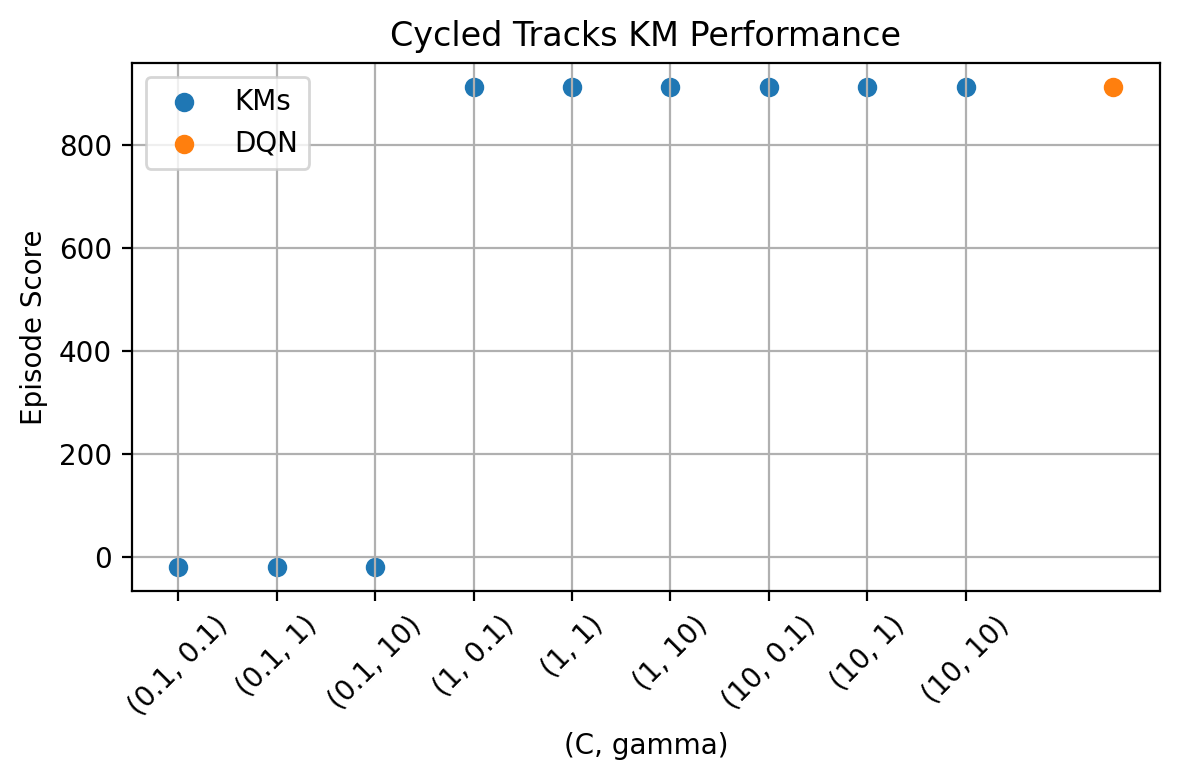

In [9]:
reward_files = sorted(glob.glob(os.path.join(model_folder,'*rewards*')),key=os.path.getmtime)

rewards = []

for rew_file in reward_files:
    with h5py.File(rew_file,'r') as f:
        rewards.append(np.mean(f['ep_rewards'][:]))
rewards = np.array(rewards)

sort_by_rewards = True

if sort_by_rewards:
    rewards_sort = np.sort(rewards)
    sort_args = np.argsort(rewards)
    C_gammas_sorted = [C_gamma_list[i] for i in sort_args]
    C_gamma_str = [str(C_gamma) for C_gamma in C_gammas_sorted]
    plt.figure(dpi=200)
    plt.scatter(np.arange(len(C_gamma_str)),rewards_sort,label='KMs')
else:
    plt.figure(dpi=200)
    plt.stem(val_scores)
    C_gamma_str = [str(C_gamma) for C_gamma in C_gamma_list]

plt.scatter(len(C_gamma_str)+0.5,np.mean(dqn_reward),label='DQN')

plt.xticks(ticks=np.arange(len(C_gamma_str)),labels=C_gamma_str,rotation='45')
plt.grid()
plt.xlabel('(C, gamma)')
plt.ylabel('Episode Score')
plt.legend()
#plt.ylim((0,950))
if track_type == 'Square':
    plt.title('Square Track KM Performance')
elif track_type == 'Ellipse':
    plt.title('Elliptical Track KM Performance')
elif track_type == 'ZigZag':
    plt.title('ZigZag Track KM Performance')
elif track_type == 'Cycle':
    plt.title('Cycled Tracks KM Performance')
plt.tight_layout()
plt.savefig(os.path.join(model_folder,track_type+'_performance_plot.jpg'))